In [276]:
import pickle
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Test Data (Amazon)

In [277]:
df = pd.read_csv('test_amazon_dataset.csv', sep='\|\|\|', engine='python')
text_list_amazon = list(map(str, df['Text'].tolist()))

Y_amazon = np.array(df['Feedback'])

max_length = 35

# Test Data (General)

In [278]:
df = pd.read_csv('test_general_dataset.csv', sep='\|\|\|', engine='python')
text_list_general = list(map(str, df['Text'].tolist()))

Y_general = np.array(df['Feedback'])

### ===================
# TESTING
### ===================

In [279]:
class Simple_Classifier:
    def __init__(self, min_number=2):
        self.min_number = min_number
        self.keywords = {
            "good": 110,
            "great": 160,
            "like": 208,
            "time": 52,
            "would": 41,
            "should": 41,
            "would recommend": 10000,
            "really": 142,
            "come back": 323,
            "get": 39,
            "go": 35,
            "nice": 900,
            "best": 310,
            "well": 100,
            "always": 206,
            "love": 391,
            "little": 257,
            "staff": 784,
            "pretty": 799,
            "first": 2064,
            "never": 138,
            "friendly": 2784,
            "people": 62,
            "much": 298,
            "definitely": 2005,
            "restaurant": 1118,
            "recommend": 1699,
            "could": 71,
            "amazing": 2314,
            "better": 453,
            "experience": 1185,
            "order": 685,
            "come": 70,
            "around": 265,
            "right": 193,
            "delicious": 100000,
            "every": 172,
            "make": 45,
            "menu": 3113,
            "way": 84,
            "still": 126,
            "night": 209,
            "wait": 401,
            "minutes": 309,
            "ever": 281,
        }
        self.keyword_set = set(self.keywords.keys())

    def evaluate(self, X, Y):
        correct = 0
        for x, y in zip(X, Y):
            if self.predict(x) == y:
                correct += 1
        return (correct * 1.0) / len(X)

    def predict_all(self, X):
        return map(self.predict, X)

    def predict(self, x):
        tweet_set = set(x.split())
        shared_words = self.keyword_set & tweet_set
        return len(shared_words) >= self.min_number

In [280]:
# create model
model = Simple_Classifier(2)

In [281]:
print('KEYWORD CLASSIFIER\n')
print('AMAZON')
print('accuracy: %s' % model.evaluate(text_list_amazon, Y_amazon))
    
fmeasure = f1_score(Y_amazon, model.predict_all(text_list_amazon), average=None)
print('fmeasure: %s\t%s' % (np.mean(fmeasure), fmeasure))
precision = precision_score(Y_amazon, model.predict_all(text_list_amazon), average=None)
print('precision: %s\t%s' % (np.mean(precision), precision))
recall = recall_score(Y_amazon, model.predict_all(text_list_amazon), average=None)
print('recall: %s\t%s' % (np.mean(recall), recall))

print('roc_auc: %s' % roc_auc_score(Y_amazon, model.predict_all(text_list_amazon)))

print('\n')
print('GENERAL')
print('accuracy: %s' % model.evaluate(text_list_general, Y_general))
    
fmeasure = f1_score(Y_general, model.predict_all(text_list_general), average=None)
print('fmeasure: %s\t%s' % (np.mean(fmeasure), fmeasure))
precision = precision_score(Y_general, model.predict_all(text_list_general), average=None)
print('precision: %s\t%s' % (np.mean(precision), precision))
recall = recall_score(Y_general, model.predict_all(text_list_general), average=None)
print('recall: %s\t%s' % (np.mean(recall), recall))

print('roc_auc: %s' % roc_auc_score(Y_general, model.predict_all(text_list_general)))

KEYWORD CLASSIFIER

AMAZON
accuracy: 0.808585055644
fmeasure: 0.5761402387041773	[0.89002558 0.2622549 ]
precision: 0.6347253886010362	[0.84145078 0.428     ]
recall: 0.5667990441963289	[0.94455215 0.18904594]
roc_auc: 0.5667990441963289


GENERAL
accuracy: 0.70753323486
fmeasure: 0.5719677617125631	[0.81285444 0.33108108]
precision: 0.5729063728685267	[0.89958159 0.24623116]
recall: 0.6232669747600427	[0.74137931 0.50515464]
roc_auc: 0.6232669747600427


In [282]:
fpr_simple, tpr_simple, thresholds = roc_curve(Y_amazon, model.predict_all(text_list_amazon), pos_label=1)
auc_simple = roc_auc_score(Y_amazon, model.predict_all(text_list_amazon))

## General Model

In [283]:
# load model and tokenizer
model = load_model('general_model.h5')
tokenizer = pickle.load(open('general_tokenizer.p', 'rb'))

In [284]:
# prepare test data
text_matrix_amazon = tokenizer.texts_to_sequences(text_list_amazon)
X_amazon = sequence.pad_sequences(text_matrix_amazon, maxlen=max_length, padding='pre', truncating='post')

text_matrix_general = tokenizer.texts_to_sequences(text_list_general)
X_general = sequence.pad_sequences(text_matrix_general, maxlen=max_length, padding='pre', truncating='post')

In [285]:
print('GENERAL MODEL\n')

# test on amazon data
print('AMAZON')
metrics = zip(model.metrics_names, model.evaluate(X_amazon, Y_amazon))
for metric, val in metrics:
    print('%s: %s' %(metric, val))
    
fmeasure = f1_score(Y_amazon, model.predict(X_amazon) > 0.5, average=None)
print('fmeasure: %s\t%s' % (np.mean(fmeasure), fmeasure))
precision = precision_score(Y_amazon, model.predict(X_amazon)> 0.5, average=None)
print('precision: %s\t%s' % (np.mean(precision), precision))
recall = recall_score(Y_amazon, model.predict(X_amazon)> 0.5, average=None)
print('recall: %s\t%s' % (np.mean(recall), recall))

print('roc_auc: %s' % roc_auc_score(Y_amazon, model.predict(X_amazon)))


# test on general data
print('\n')
print('GENERAL')
metrics = zip(model.metrics_names, model.evaluate(X_general, Y_general))
for metric, val in metrics:
    print('%s: %s' %(metric, val))
    
fmeasure = f1_score(Y_general, (model.predict(X_general) > 0.5).astype(int), average=None)
print('fmeasure: %s\t%s' % (np.mean(fmeasure), fmeasure))
precision = precision_score(Y_general, model.predict(X_general) > 0.5, average=None)
print('precision: %s\t%s' % (np.mean(precision), precision))
recall = recall_score(Y_general, model.predict(X_general) > 0.5, average=None)
print('recall: %s\t%s' % (np.mean(recall), recall))

print('roc_auc: %s' % roc_auc_score(Y_general, model.predict(X_general)))

GENERAL MODEL

AMAZON
3145/3145 [==============================] - 4s 1ms/step
loss: 0.6878026232733029
binary_accuracy: 0.8190779014308426
fmeasure: 0.6149055558245506	[0.89530819 0.33450292]
precision: 0.6733502224419179	[0.85189076 0.49480969]
recall: 0.5980195435544223	[0.94338891 0.25265018]
roc_auc: 0.7576569793808923


GENERAL
677/677 [==============================] - 0s 501us/step
loss: 0.7895219441354715
binary_accuracy: 0.7548005908419497
fmeasure: 0.5428057671027794	[0.85413005 0.23148148]
precision: 0.5405258877744646	[0.87096774 0.21008403]
recall: 0.5478314966228226	[0.83793103 0.25773196]
roc_auc: 0.5785193743334518


In [286]:
fpr_general, tpr_general, _ = roc_curve(Y_amazon, model.predict(X_amazon), pos_label=1)
auc_general = roc_auc_score(Y_amazon, model.predict(X_amazon))

In [287]:
print auc_general

0.7576569793808923


## General + Reviews Model

In [288]:
# load model and tokenizer
model = load_model('general+reviews_model.h5')
tokenizer = pickle.load(open('general+reviews_tokenizer.p', 'rb'))

In [289]:
# prepare test data
text_matrix_amazon = tokenizer.texts_to_sequences(text_list_amazon)
X_amazon = sequence.pad_sequences(text_matrix_amazon, maxlen=max_length, padding='pre', truncating='post')

text_matrix_general = tokenizer.texts_to_sequences(text_list_general)
X_general = sequence.pad_sequences(text_matrix_general, maxlen=max_length, padding='pre', truncating='post')

In [290]:
print('GENERAL + REVIEWS MODEL\n')

# test on amazon data
print('AMAZON')
metrics = zip(model.metrics_names, model.evaluate(X_amazon, Y_amazon))
for metric, val in metrics:
    print('%s: %s' %(metric, val))
    
fmeasure = f1_score(Y_amazon, model.predict(X_amazon) > 0.5, average=None)
print('fmeasure: %s\t%s' % (np.mean(fmeasure), fmeasure))
precision = precision_score(Y_amazon, model.predict(X_amazon)> 0.5, average=None)
print('precision: %s\t%s' % (np.mean(precision), precision))
recall = recall_score(Y_amazon, model.predict(X_amazon)> 0.5, average=None)
print('recall: %s\t%s' % (np.mean(recall), recall))

print('roc_auc: %s' % roc_auc_score(Y_amazon, model.predict(X_amazon)))


# test on general data
print('\n')
print('GENERAL')
metrics = zip(model.metrics_names, model.evaluate(X_general, Y_general))
for metric, val in metrics:
    print('%s: %s' %(metric, val))
    
fmeasure = f1_score(Y_general, (model.predict(X_general) > 0.5).astype(int), average=None)
print('fmeasure: %s\t%s' % (np.mean(fmeasure), fmeasure))
precision = precision_score(Y_general, model.predict(X_general) > 0.5, average=None)
print('precision: %s\t%s' % (np.mean(precision), precision))
recall = recall_score(Y_general, model.predict(X_general) > 0.5, average=None)
print('recall: %s\t%s' % (np.mean(recall), recall))

print('roc_auc: %s' % roc_auc_score(Y_general, model.predict(X_general)))

GENERAL + REVIEWS MODEL

AMAZON
3145/3145 [==============================] - 4s 1ms/step
loss: 1.3869585274133849
binary_accuracy: 0.6610492846166007
fmeasure: 0.6022739136046649	[0.75516766 0.44938017]
precision: 0.621857715636887	[0.92619718 0.31751825]
recall: 0.7030038075951865	[0.63745638 0.76855124]
roc_auc: 0.7736399048032697


GENERAL
677/677 [==============================] - 0s 549us/step
loss: 1.3697638550396332
binary_accuracy: 0.6366322009743053
fmeasure: 0.516933518969718	[0.75739645 0.27647059]
precision: 0.5391041322940965	[0.88479263 0.19341564]
recall: 0.5733025239957341	[0.66206897 0.48453608]
roc_auc: 0.6101759687166726


## Amazon Model

In [291]:
# load model and tokenizer
model = load_model('amazon_model.h5')
tokenizer = pickle.load(open('amazon_tokenizer.p', 'rb'))

In [292]:
# prepare test data
text_matrix_amazon = tokenizer.texts_to_sequences(text_list_amazon)
X_amazon = sequence.pad_sequences(text_matrix_amazon, maxlen=max_length, padding='pre', truncating='post')

text_matrix_general = tokenizer.texts_to_sequences(text_list_general)
X_general = sequence.pad_sequences(text_matrix_general, maxlen=max_length, padding='pre', truncating='post')

In [293]:
print('AMAZON MODEL\n')

# test on amazon data
print('AMAZON')
metrics = zip(model.metrics_names, model.evaluate(X_amazon, Y_amazon))
for metric, val in metrics:
    print('%s: %s' %(metric, val))
    
fmeasure = f1_score(Y_amazon, model.predict(X_amazon) > 0.5, average=None)
print('fmeasure: %s\t%s' % (np.mean(fmeasure), fmeasure))
precision = precision_score(Y_amazon, model.predict(X_amazon)> 0.5, average=None)
print('precision: %s\t%s' % (np.mean(precision), precision))
recall = recall_score(Y_amazon, model.predict(X_amazon)> 0.5, average=None)
print('recall: %s\t%s' % (np.mean(recall), recall))

print('roc_auc: %s' % roc_auc_score(Y_amazon, model.predict(X_amazon)))


# test on general data
print('\n')
print('GENERAL')
metrics = zip(model.metrics_names, model.evaluate(X_general, Y_general))
for metric, val in metrics:
    print('%s: %s' %(metric, val))
    
fmeasure = f1_score(Y_general, (model.predict(X_general) > 0.5).astype(int), average=None)
print('fmeasure: %s\t%s' % (np.mean(fmeasure), fmeasure))
precision = precision_score(Y_general, model.predict(X_general) > 0.5, average=None)
print('precision: %s\t%s' % (np.mean(precision), precision))
recall = recall_score(Y_general, model.predict(X_general) > 0.5, average=None)
print('recall: %s\t%s' % (np.mean(recall), recall))

print('roc_auc: %s' % roc_auc_score(Y_general, model.predict(X_general)))

AMAZON MODEL

AMAZON
3145/3145 [==============================] - 4s 1ms/step
loss: 0.4842183566529345
binary_accuracy: 0.8174880763116057
fmeasure: 0.6954197643844787	[0.88823988 0.50259965]
precision: 0.6926291439532403	[0.89206101 0.49319728]
recall: 0.6984094144469396	[0.88445134 0.51236749]
roc_auc: 0.811728530383349


GENERAL
677/677 [==============================] - 0s 513us/step
loss: 0.7065875544990007
binary_accuracy: 0.7636632200886263
fmeasure: 0.5102188460842828	[0.86254296 0.15789474]
precision: 0.5104396818382678	[0.85958904 0.16129032]
recall: 0.5100782083185211	[0.86551724 0.15463918]
roc_auc: 0.5551102026306434


In [294]:
fpr_amazon, tpr_amazon, _ = roc_curve(Y_amazon, model.predict(X_amazon), pos_label=1)
auc_amazon = roc_auc_score(Y_amazon, model.predict(X_amazon))
print auc_amazon

0.811728530383349


# ROC Curve

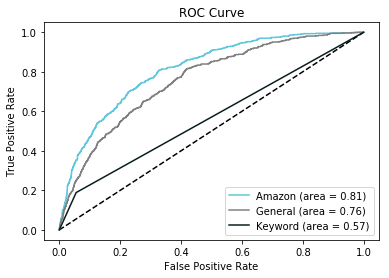

In [309]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_amazon, tpr_amazon, label='Amazon (area = {0:0.2f})'.format(amazon_auc), color='#5ec7db')
plt.plot(fpr_general, tpr_general, label='General (area = {0:0.2f})'.format(auc_general), color='gray')
plt.plot(fpr_simple, tpr_simple, label='Keyword (area = {0:0.2f})'.format(auc_simple), color='#081c1f')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig('roc_curve_FOR_CLAY.png')